[View in Colaboratory](https://colab.research.google.com/github/yylonly/GoogleCoLab/blob/master/4_ServeNet_1DCNN_Bi_LTSM_(Glove200b_trainedEmbeddingLayer).ipynb)

## ServeNet-LTSM (Glove50b-trainedEmbeddingLayer)

In [0]:
!kill -9 -1

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import os
os.chdir("/content/drive/Colab Notebooks/")

In [4]:
!ls -l

total 10354
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 00:16 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 00:16 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  771179 May  6 07:14 4.ServeNet-1DCNN-Bi-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root    1191 May  5 20:56 BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  5 20:56 BI-LTSM-glove50-top5.pdf
-rw-r--r-- 1 root root   48080 Mar 29 16:22 CalligraphyColorNet.ipynb
-rw-r--r-- 1 root root 1377049 Mar 19

In [5]:
# To support current plaidml using Keras 2.0.8
import keras; print(keras.__version__)
!pip install keras==2.0.8
import keras; print(keras.__version__)

Using TensorFlow backend.


2.1.6
    100% |████████████████████████████████| 276kB 4.0MB/s 
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6
2.1.6


In [0]:
#import plaidml.keras
#plaidml.keras.install_backend()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D, AveragePooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import Bidirectional

np.random.seed(0)
%matplotlib inline

In [7]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [8]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [9]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.200d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
# GRADED FUNCTION: Emojify_V2

def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
    
        
  
    X = Conv1D(256, 3, activation='relu')(embeddings)
    X = Conv1D(256, 3, activation='relu')(X)

#    X = Conv1D(256, 5, activation='relu')(X)
#    X = Conv1D(512, 3, activation='relu')(X)
#     X = MaxPooling1D()(X)
        
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = Bidirectional(LSTM(256, return_sequences=True))(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(256, return_sequences=False))(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(50)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
maxLen = 110

In [52]:
model = ServeNet((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 110, 200)          80000200  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 108, 256)          153856    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 106, 256)          196864    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 106, 512)          1050624   
_________________________________________________________________
dropout_11 (Dropout)         (None, 106, 512)          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 512)               1574912   
__________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

In [54]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 50, batch_size = 128)

Train on 8123 samples, validate on 2061 samples
Epoch 1/50
8123/8123 [==============================] - 79s 10ms/step - loss: 3.5269 - categorical_accuracy: 0.1236 - top_k_categorical_accuracy: 0.3385 - val_loss: 3.0422 - val_categorical_accuracy: 0.2014 - val_top_k_categorical_accuracy: 0.5163
Epoch 2/50
8123/8123 [==============================] - 75s 9ms/step - loss: 2.7194 - categorical_accuracy: 0.2815 - top_k_categorical_accuracy: 0.6069 - val_loss: 2.3891 - val_categorical_accuracy: 0.3629 - val_top_k_categorical_accuracy: 0.6953
Epoch 3/50
8123/8123 [==============================] - 76s 9ms/step - loss: 2.3204 - categorical_accuracy: 0.3776 - top_k_categorical_accuracy: 0.7038 - val_loss: 2.1446 - val_categorical_accuracy: 0.4168 - val_top_k_categorical_accuracy: 0.7404
Epoch 4/50
1664/8123 [=====>........................] - ETA: 56s - loss: 2.0824 - categorical_accuracy: 0.4189 - top_k_categorical_accuracy: 0.7638

8123/8123 [==============================] - 75s 9ms/step - loss: 2.0274 - categorical_accuracy: 0.4448 - top_k_categorical_accuracy: 0.7735 - val_loss: 1.9487 - val_categorical_accuracy: 0.4794 - val_top_k_categorical_accuracy: 0.7758
Epoch 5/50
8123/8123 [==============================] - 75s 9ms/step - loss: 1.8032 - categorical_accuracy: 0.5078 - top_k_categorical_accuracy: 0.8151 - val_loss: 1.9102 - val_categorical_accuracy: 0.4925 - val_top_k_categorical_accuracy: 0.7948
Epoch 6/50
8123/8123 [==============================] - 75s 9ms/step - loss: 1.6709 - categorical_accuracy: 0.5411 - top_k_categorical_accuracy: 0.8345 - val_loss: 1.9522 - val_categorical_accuracy: 0.4770 - val_top_k_categorical_accuracy: 0.7564
Epoch 7/50
3712/8123 [============>.................] - ETA: 38s - loss: 1.5743 - categorical_accuracy: 0.5730 - top_k_categorical_accuracy: 0.8497

8123/8123 [==============================] - 76s 9ms/step - loss: 1.5437 - categorical_accuracy: 0.5844 - top_k_categorical_accuracy: 0.8585 - val_loss: 1.7364 - val_categorical_accuracy: 0.5478 - val_top_k_categorical_accuracy: 0.8093
Epoch 8/50
8123/8123 [==============================] - 75s 9ms/step - loss: 1.3726 - categorical_accuracy: 0.6229 - top_k_categorical_accuracy: 0.8844 - val_loss: 1.6590 - val_categorical_accuracy: 0.5711 - val_top_k_categorical_accuracy: 0.8307
Epoch 9/50
8123/8123 [==============================] - 75s 9ms/step - loss: 1.2557 - categorical_accuracy: 0.6548 - top_k_categorical_accuracy: 0.9020 - val_loss: 1.6501 - val_categorical_accuracy: 0.5837 - val_top_k_categorical_accuracy: 0.8394
Epoch 10/50
4096/8123 [==============>...............] - ETA: 34s - loss: 1.0618 - categorical_accuracy: 0.7073 - top_k_categorical_accuracy: 0.9265

8123/8123 [==============================] - 75s 9ms/step - loss: 1.1169 - categorical_accuracy: 0.6885 - top_k_categorical_accuracy: 0.9192 - val_loss: 1.6551 - val_categorical_accuracy: 0.5910 - val_top_k_categorical_accuracy: 0.8258
Epoch 11/50
8123/8123 [==============================] - 75s 9ms/step - loss: 1.0064 - categorical_accuracy: 0.7192 - top_k_categorical_accuracy: 0.9320 - val_loss: 1.6478 - val_categorical_accuracy: 0.5919 - val_top_k_categorical_accuracy: 0.8496
Epoch 12/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.9339 - categorical_accuracy: 0.7460 - top_k_categorical_accuracy: 0.9428 - val_loss: 1.6550 - val_categorical_accuracy: 0.5978 - val_top_k_categorical_accuracy: 0.8438
Epoch 13/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.7911 - categorical_accuracy: 0.7788 - top_k_categorical_accuracy: 0.9607

8123/8123 [==============================] - 75s 9ms/step - loss: 0.8276 - categorical_accuracy: 0.7704 - top_k_categorical_accuracy: 0.9532 - val_loss: 1.7020 - val_categorical_accuracy: 0.6065 - val_top_k_categorical_accuracy: 0.8331
Epoch 14/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.7259 - categorical_accuracy: 0.7974 - top_k_categorical_accuracy: 0.9616 - val_loss: 1.6858 - val_categorical_accuracy: 0.6046 - val_top_k_categorical_accuracy: 0.8462
Epoch 15/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.6697 - categorical_accuracy: 0.8152 - top_k_categorical_accuracy: 0.9666 - val_loss: 1.7544 - val_categorical_accuracy: 0.6002 - val_top_k_categorical_accuracy: 0.8428
Epoch 16/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.5751 - categorical_accuracy: 0.8416 - top_k_categorical_accuracy: 0.9736

8123/8123 [==============================] - 75s 9ms/step - loss: 0.6115 - categorical_accuracy: 0.8281 - top_k_categorical_accuracy: 0.9714 - val_loss: 1.7848 - val_categorical_accuracy: 0.5915 - val_top_k_categorical_accuracy: 0.8282
Epoch 17/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.5441 - categorical_accuracy: 0.8473 - top_k_categorical_accuracy: 0.9760 - val_loss: 1.8230 - val_categorical_accuracy: 0.6167 - val_top_k_categorical_accuracy: 0.8389
Epoch 18/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.4364 - categorical_accuracy: 0.8769 - top_k_categorical_accuracy: 0.9861 - val_loss: 1.8546 - val_categorical_accuracy: 0.6084 - val_top_k_categorical_accuracy: 0.8355
Epoch 19/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.3776 - categorical_accuracy: 0.8950 - top_k_categorical_accuracy: 0.9880

8123/8123 [==============================] - 75s 9ms/step - loss: 0.3900 - categorical_accuracy: 0.8904 - top_k_categorical_accuracy: 0.9870 - val_loss: 1.9403 - val_categorical_accuracy: 0.5968 - val_top_k_categorical_accuracy: 0.8307
Epoch 20/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.3476 - categorical_accuracy: 0.9016 - top_k_categorical_accuracy: 0.9879 - val_loss: 1.8898 - val_categorical_accuracy: 0.6104 - val_top_k_categorical_accuracy: 0.8438
Epoch 21/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.3095 - categorical_accuracy: 0.9112 - top_k_categorical_accuracy: 0.9916 - val_loss: 2.0517 - val_categorical_accuracy: 0.5968 - val_top_k_categorical_accuracy: 0.8331
Epoch 22/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.3578 - categorical_accuracy: 0.8982 - top_k_categorical_accuracy: 0.9893

8123/8123 [==============================] - 75s 9ms/step - loss: 0.3554 - categorical_accuracy: 0.9003 - top_k_categorical_accuracy: 0.9910 - val_loss: 2.0092 - val_categorical_accuracy: 0.6046 - val_top_k_categorical_accuracy: 0.8336
Epoch 23/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.2889 - categorical_accuracy: 0.9146 - top_k_categorical_accuracy: 0.9930 - val_loss: 2.0725 - val_categorical_accuracy: 0.5983 - val_top_k_categorical_accuracy: 0.8287
Epoch 24/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.2325 - categorical_accuracy: 0.9332 - top_k_categorical_accuracy: 0.9954 - val_loss: 2.0293 - val_categorical_accuracy: 0.6215 - val_top_k_categorical_accuracy: 0.8370
Epoch 25/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.1866 - categorical_accuracy: 0.9509 - top_k_categorical_accuracy: 0.9956

8123/8123 [==============================] - 75s 9ms/step - loss: 0.2027 - categorical_accuracy: 0.9450 - top_k_categorical_accuracy: 0.9956 - val_loss: 2.1475 - val_categorical_accuracy: 0.6075 - val_top_k_categorical_accuracy: 0.8394
Epoch 26/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.2084 - categorical_accuracy: 0.9403 - top_k_categorical_accuracy: 0.9963 - val_loss: 2.2349 - val_categorical_accuracy: 0.6046 - val_top_k_categorical_accuracy: 0.8394
Epoch 27/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.2105 - categorical_accuracy: 0.9382 - top_k_categorical_accuracy: 0.9979 - val_loss: 2.2223 - val_categorical_accuracy: 0.6060 - val_top_k_categorical_accuracy: 0.8438
Epoch 28/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.1684 - categorical_accuracy: 0.9548 - top_k_categorical_accuracy: 0.9985

8123/8123 [==============================] - 75s 9ms/step - loss: 0.1771 - categorical_accuracy: 0.9516 - top_k_categorical_accuracy: 0.9982 - val_loss: 2.2449 - val_categorical_accuracy: 0.5997 - val_top_k_categorical_accuracy: 0.8355
Epoch 29/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.1459 - categorical_accuracy: 0.9591 - top_k_categorical_accuracy: 0.9985 - val_loss: 2.3491 - val_categorical_accuracy: 0.5987 - val_top_k_categorical_accuracy: 0.8311
Epoch 30/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.1426 - categorical_accuracy: 0.9589 - top_k_categorical_accuracy: 0.9985 - val_loss: 2.2569 - val_categorical_accuracy: 0.6060 - val_top_k_categorical_accuracy: 0.8355
Epoch 31/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.1045 - categorical_accuracy: 0.9731 - top_k_categorical_accuracy: 0.9990

8123/8123 [==============================] - 75s 9ms/step - loss: 0.1060 - categorical_accuracy: 0.9708 - top_k_categorical_accuracy: 0.9994 - val_loss: 2.3474 - val_categorical_accuracy: 0.6167 - val_top_k_categorical_accuracy: 0.8394
Epoch 32/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.1030 - categorical_accuracy: 0.9698 - top_k_categorical_accuracy: 0.9991 - val_loss: 2.3159 - val_categorical_accuracy: 0.6157 - val_top_k_categorical_accuracy: 0.8336
Epoch 33/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.0841 - categorical_accuracy: 0.9759 - top_k_categorical_accuracy: 0.9989 - val_loss: 2.3469 - val_categorical_accuracy: 0.6215 - val_top_k_categorical_accuracy: 0.8282
Epoch 34/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.0591 - categorical_accuracy: 0.9868 - top_k_categorical_accuracy: 0.9993

8123/8123 [==============================] - 75s 9ms/step - loss: 0.0580 - categorical_accuracy: 0.9863 - top_k_categorical_accuracy: 0.9995 - val_loss: 2.4638 - val_categorical_accuracy: 0.6099 - val_top_k_categorical_accuracy: 0.8341
Epoch 35/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.0449 - categorical_accuracy: 0.9887 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.4998 - val_categorical_accuracy: 0.6201 - val_top_k_categorical_accuracy: 0.8321
Epoch 36/50
8123/8123 [==============================] - 74s 9ms/step - loss: 0.0578 - categorical_accuracy: 0.9834 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5484 - val_categorical_accuracy: 0.5992 - val_top_k_categorical_accuracy: 0.8234
Epoch 37/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.0716 - categorical_accuracy: 0.9792 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 75s 9ms/step - loss: 0.0715 - categorical_accuracy: 0.9798 - top_k_categorical_accuracy: 0.9995 - val_loss: 2.5481 - val_categorical_accuracy: 0.6080 - val_top_k_categorical_accuracy: 0.8253
Epoch 38/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.1035 - categorical_accuracy: 0.9714 - top_k_categorical_accuracy: 0.9986 - val_loss: 2.6182 - val_categorical_accuracy: 0.5822 - val_top_k_categorical_accuracy: 0.8132
Epoch 39/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.1408 - categorical_accuracy: 0.9562 - top_k_categorical_accuracy: 0.9982 - val_loss: 2.5282 - val_categorical_accuracy: 0.6002 - val_top_k_categorical_accuracy: 0.8331
Epoch 40/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.1121 - categorical_accuracy: 0.9663 - top_k_categorical_accuracy: 0.9993

8123/8123 [==============================] - 74s 9ms/step - loss: 0.1224 - categorical_accuracy: 0.9639 - top_k_categorical_accuracy: 0.9989 - val_loss: 2.5415 - val_categorical_accuracy: 0.6065 - val_top_k_categorical_accuracy: 0.8151
Epoch 41/50
8123/8123 [==============================] - 74s 9ms/step - loss: 0.1290 - categorical_accuracy: 0.9643 - top_k_categorical_accuracy: 0.9990 - val_loss: 2.5729 - val_categorical_accuracy: 0.5978 - val_top_k_categorical_accuracy: 0.8151
Epoch 42/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.1246 - categorical_accuracy: 0.9612 - top_k_categorical_accuracy: 0.9991 - val_loss: 2.5811 - val_categorical_accuracy: 0.6041 - val_top_k_categorical_accuracy: 0.8214
Epoch 43/50
4096/8123 [==============>...............] - ETA: 33s - loss: 0.0940 - categorical_accuracy: 0.9717 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 74s 9ms/step - loss: 0.1001 - categorical_accuracy: 0.9709 - top_k_categorical_accuracy: 0.9994 - val_loss: 2.5857 - val_categorical_accuracy: 0.6007 - val_top_k_categorical_accuracy: 0.8161
Epoch 44/50
8123/8123 [==============================] - 74s 9ms/step - loss: 0.0812 - categorical_accuracy: 0.9761 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.6334 - val_categorical_accuracy: 0.6080 - val_top_k_categorical_accuracy: 0.8224
Epoch 45/50
8123/8123 [==============================] - 74s 9ms/step - loss: 0.0901 - categorical_accuracy: 0.9732 - top_k_categorical_accuracy: 0.9988 - val_loss: 2.5825 - val_categorical_accuracy: 0.6065 - val_top_k_categorical_accuracy: 0.8214
Epoch 46/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.0739 - categorical_accuracy: 0.9800 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 74s 9ms/step - loss: 0.0685 - categorical_accuracy: 0.9817 - top_k_categorical_accuracy: 0.9995 - val_loss: 2.6655 - val_categorical_accuracy: 0.6012 - val_top_k_categorical_accuracy: 0.8311
Epoch 47/50
8123/8123 [==============================] - 74s 9ms/step - loss: 0.0602 - categorical_accuracy: 0.9829 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.6196 - val_categorical_accuracy: 0.6215 - val_top_k_categorical_accuracy: 0.8287
Epoch 48/50
8123/8123 [==============================] - 74s 9ms/step - loss: 0.0403 - categorical_accuracy: 0.9887 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6999 - val_categorical_accuracy: 0.6162 - val_top_k_categorical_accuracy: 0.8273
Epoch 49/50
4096/8123 [==============>...............] - ETA: 34s - loss: 0.0375 - categorical_accuracy: 0.9895 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 75s 9ms/step - loss: 0.0398 - categorical_accuracy: 0.9890 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.7096 - val_categorical_accuracy: 0.6036 - val_top_k_categorical_accuracy: 0.8263
Epoch 50/50
8123/8123 [==============================] - 75s 9ms/step - loss: 0.0275 - categorical_accuracy: 0.9931 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.7700 - val_categorical_accuracy: 0.6118 - val_top_k_categorical_accuracy: 0.8244


In [55]:
!ls -l

total 10329
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 09:07 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 09:07 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  745823 May  6 10:15 4.ServeNet-1DCNN-Bi-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root    1191 May  5 20:56 BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  5 20:56 BI-LTSM-glove50-top5.pdf
-rw-r--r-- 1 root root   48080 Mar 29 16:22 CalligraphyColorNet.ipynb
-rw-r--r-- 1 root root 1377049 Mar 19

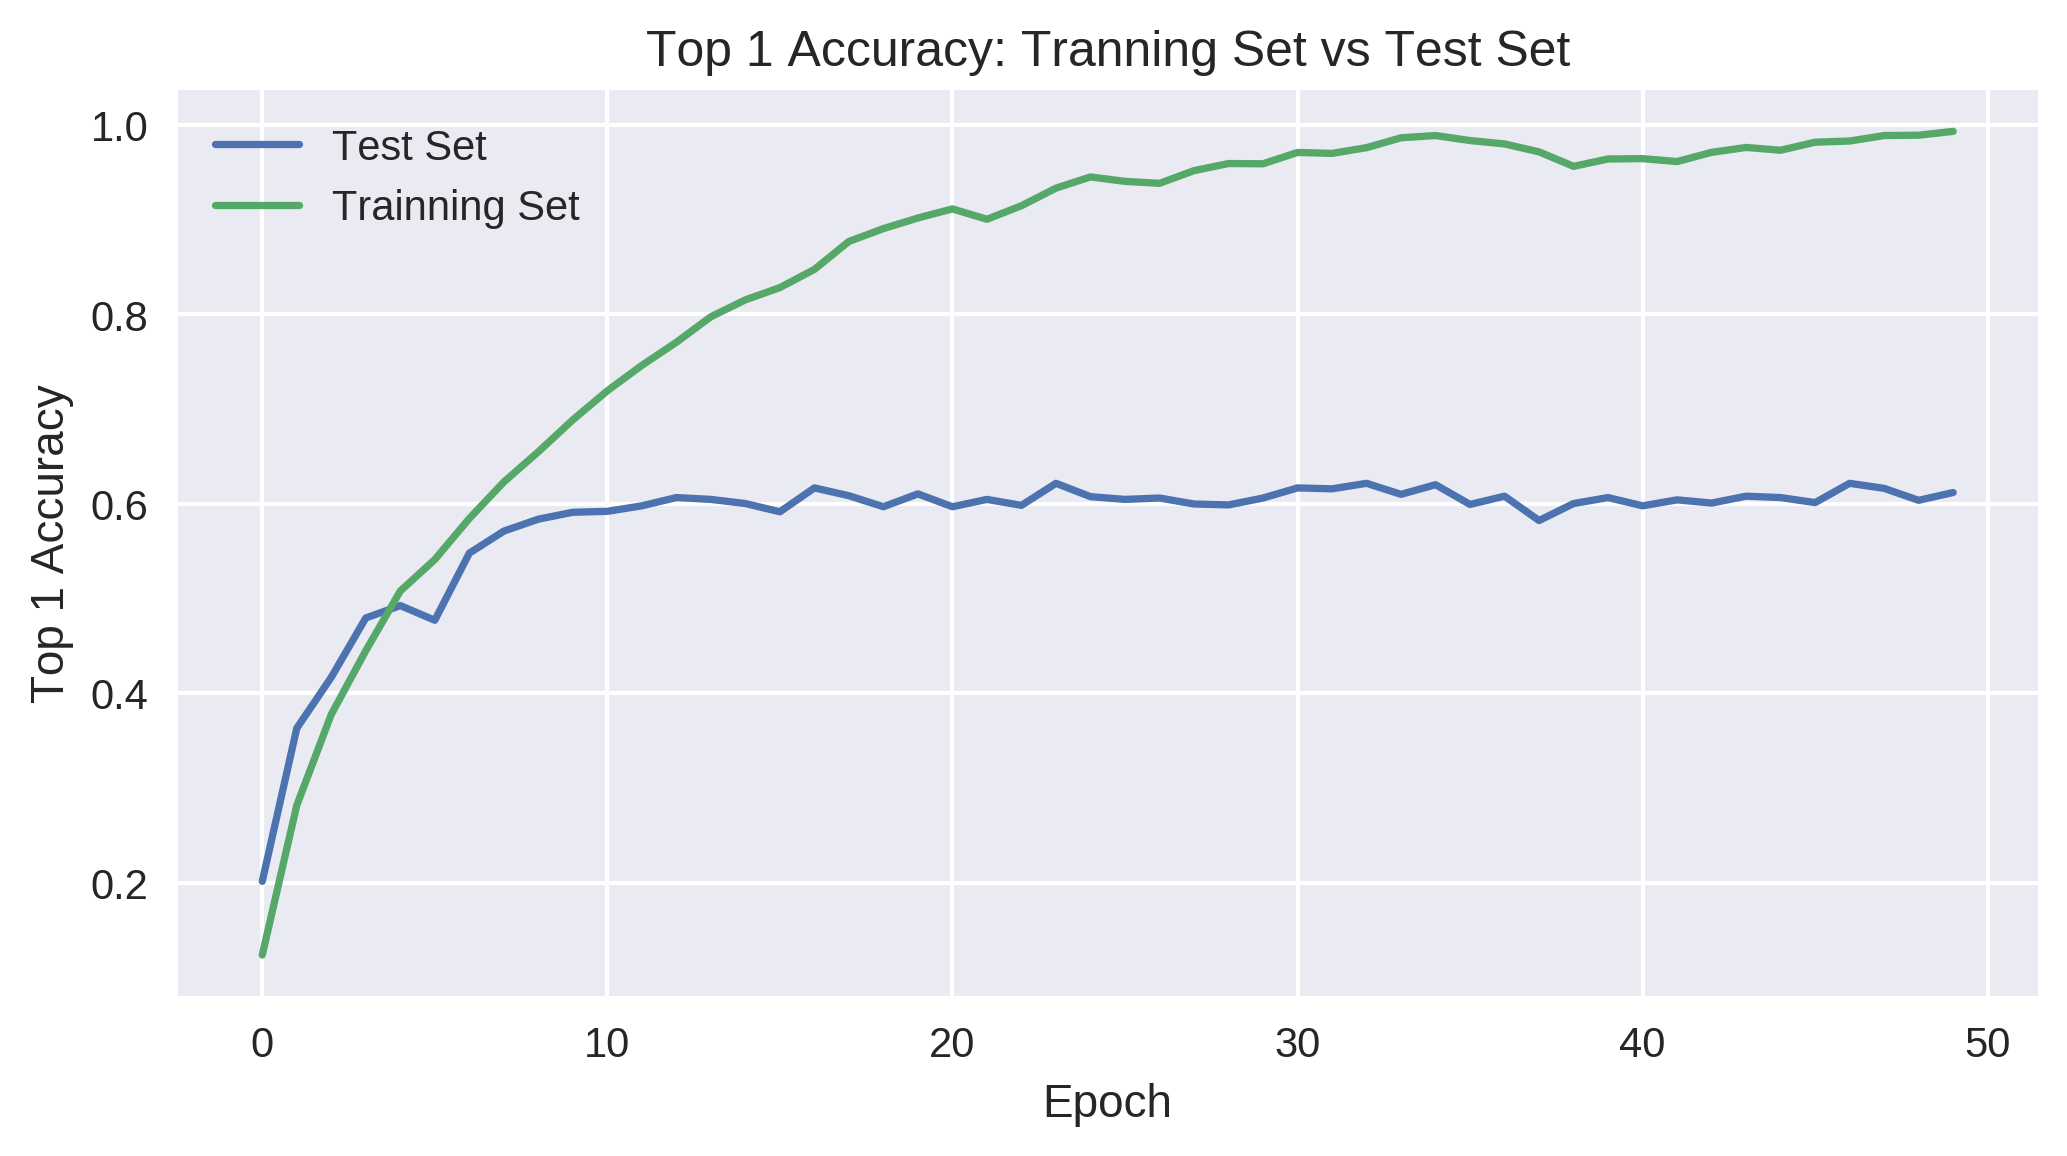

In [56]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()

### Plot Loss

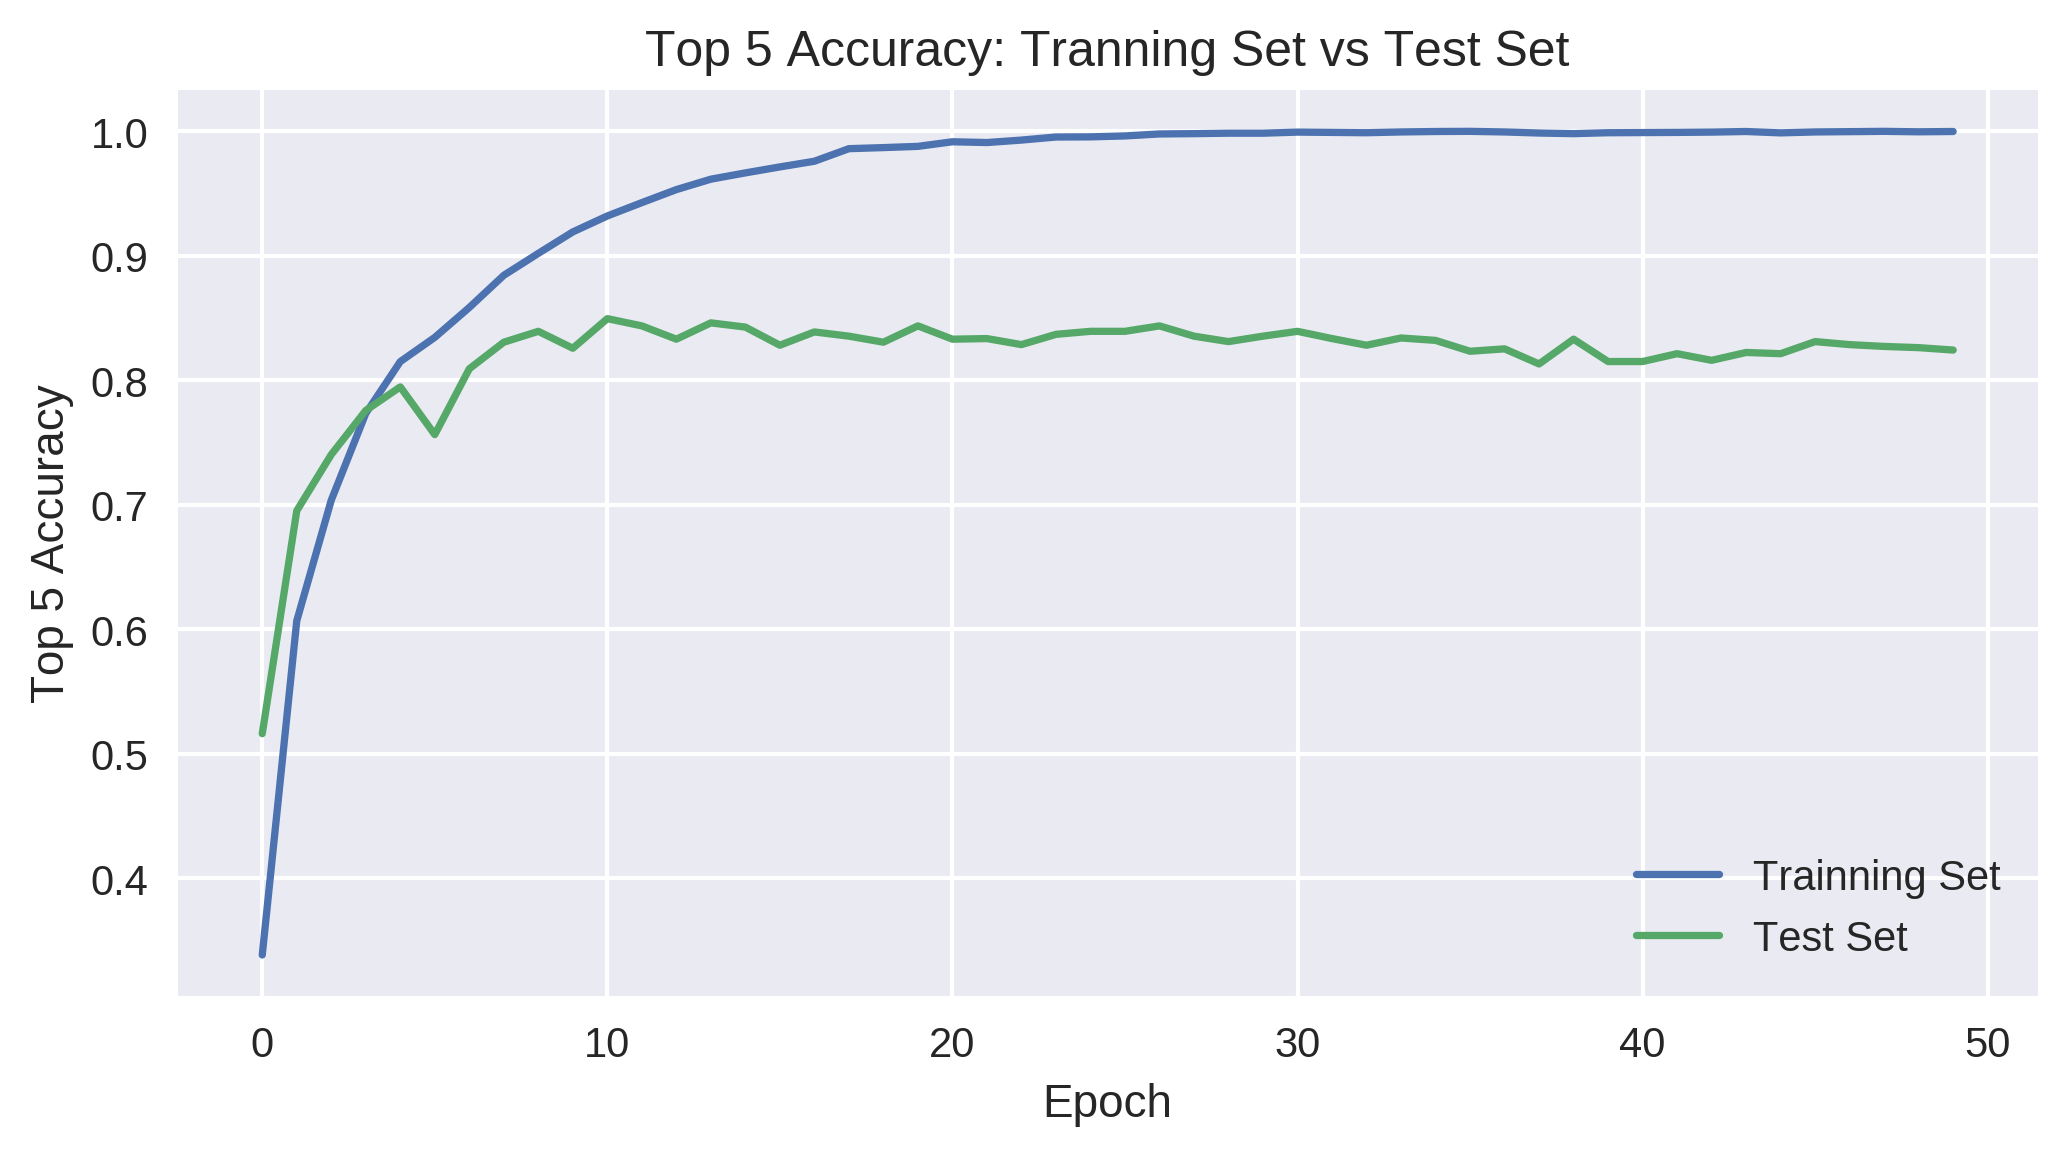

In [57]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig('1DCNN-BI-LTSM-glove50-top5.pdf', format='pdf', dpi=300)

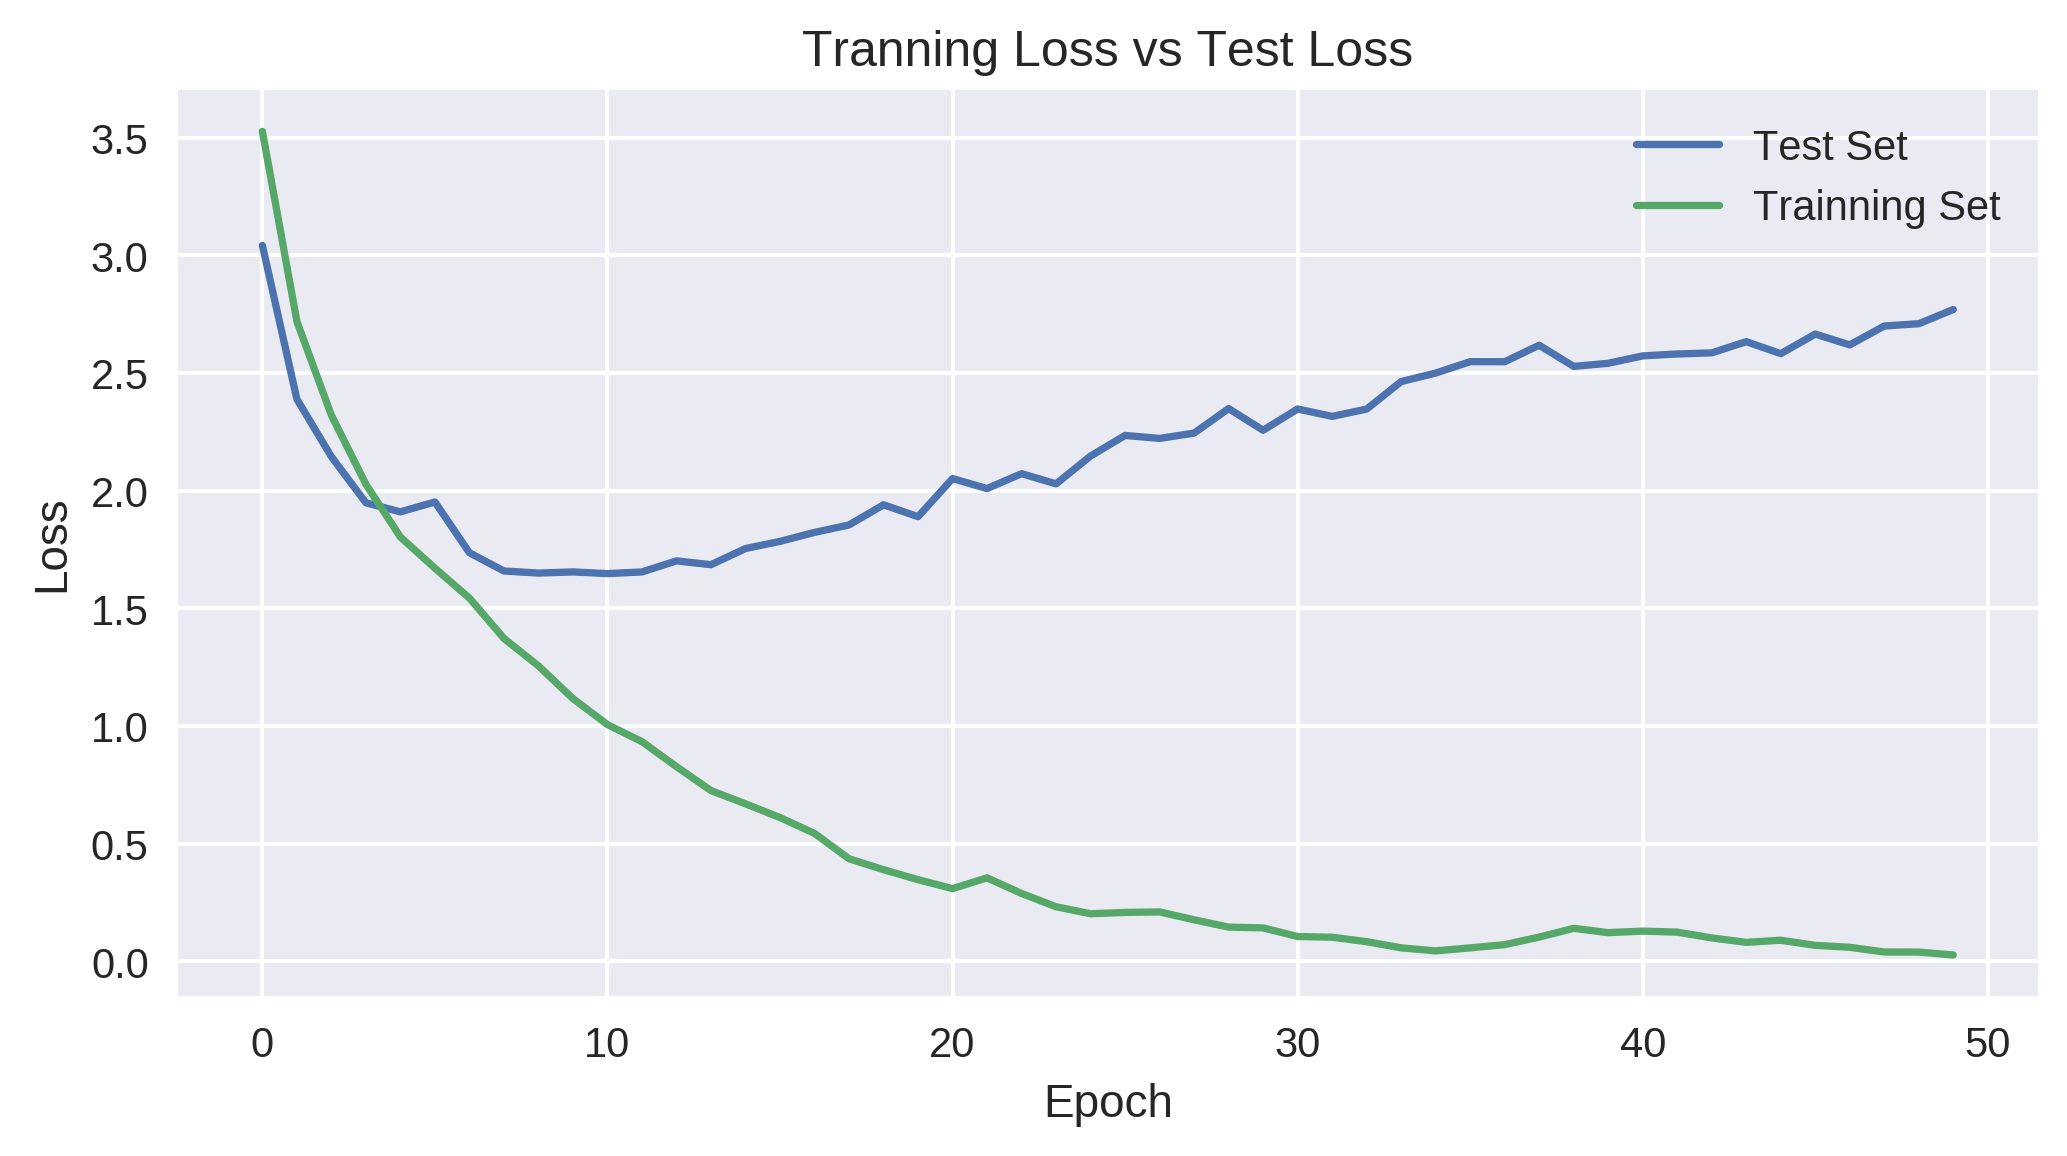

In [58]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('1D-CNN-BI-LTSM-glove50-loss.pdf', format='pdf', dpi=300)

### Save History

In [0]:
import pickle
  
f = open('ServeNet/1DCNNBiLTSMtrainHistoryDictGlove200', 'wb')
pickle.dump(history.history, f)
f.close()
  

### Load History

In [0]:
f = open('ServeNet/1DCNNBiLTSMtrainHistoryDictGlove200', 'rb')
his = pickle.load(f)
f.close()

In [61]:
val_top_k = his['val_top_k_categorical_accuracy']
print(max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print(min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print(max(val_ca))
print(np.argmax(val_ca))

0.8495875789609018
10
1.64782274943541
10
0.6215429404937545
32


### Model Save

In [0]:
model.save('ServeNet/Serve_Net_1DCNN_BI_LTSM_Glove200.h5') 

### Model Load

In [0]:
model = load_model('ServeNet/Serve_Net_1DCNN_BI_LTSM_Glove200.h5')

In [64]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 71s 9ms/step
Training accuracy =  1.0
Test set:
2061/2061 [==============================] - 18s 9ms/step
Training accuracy =  0.824357108315584


In [0]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict(X_test)

In [66]:
print(predY_test.shape)
print(Y_test.shape)

(2061, 50)
(2061, 50)


In [67]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

46
21


In [68]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = ['Financial', 'Project Management', 'Banking', 'Backend', 'Shipping', 'File Sharing', 'Email', 'Mapping', 'Domains', 'Social', 'Weather', 'Storage', 'Tools', 'Games', 'Events', 'Security', 'Analytics', 'Travel', 'Data', 'Reference', 'Office', 'Medical', 'Photos', 'Images', 'Education', 'Cloud', 'Chat', 'Application Development', 'Database', 'Messaging', 'News Services', 'Advertising', 'eCommerce', 'Transportation', 'Government', 'Other', 'Music', 'Sports', 'Internet of Things', 'Science', 'Telephony', 'Stocks', 'Media', 'Entertainment', 'Payments', 'Real Estate', 'Bitcoin', 'Search', 'Enterprise', 'Video', 'All']

print(non_onehot_pred_test.shape)
print(non_onehot_Y_test.shape)


(2061,)
(2061,)


In [0]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)  

In [70]:
cross.head()

Predicted,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,All
Actual,,,,,,,,,,,,,,,,,,,,,
0,11,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
1,0,31,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,2,0,0,41
2,0,0,29,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,39
3,0,0,0,7,0,0,1,0,0,0,...,0,0,0,0,0,2,0,0,0,16
4,0,1,1,0,9,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,28


In [71]:
cross.index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
          20,    21,    22,    23,    24,    25,    26,    27,    28,    29,
          30,    31,    32,    33,    34,    35,    36,    37,    38,    39,
          40,    41,    42,    43,    44,    45,    46,    47,    48,    49,
       'All'],
      dtype='object', name='Actual')

In [72]:
cross.columns

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
          20,    21,    22,    23,    24,    25,    26,    27,    28,    29,
          30,    31,    32,    33,    34,    35,    36,    37,    38,    39,
          40,    41,    42,    43,    44,    45,    46,    47,    48,    49,
       'All'],
      dtype='object', name='Predicted')

In [73]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Financial,Project Management,Banking,Backend,Shipping,File Sharing,Email,Mapping,Domains,Social,...,Stocks,Media,Entertainment,Payments,Real Estate,Bitcoin,Search,Enterprise,Video,All
Actual,,,,,,,,,,,,,,,,,,,,,
Financial,11,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
Project Management,0,31,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,2,0,0,41
Banking,0,0,29,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,39
Backend,0,0,0,7,0,0,1,0,0,0,...,0,0,0,0,0,2,0,0,0,16
Shipping,0,1,1,0,9,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,28


In [74]:
sns.load_dataset("flights").head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


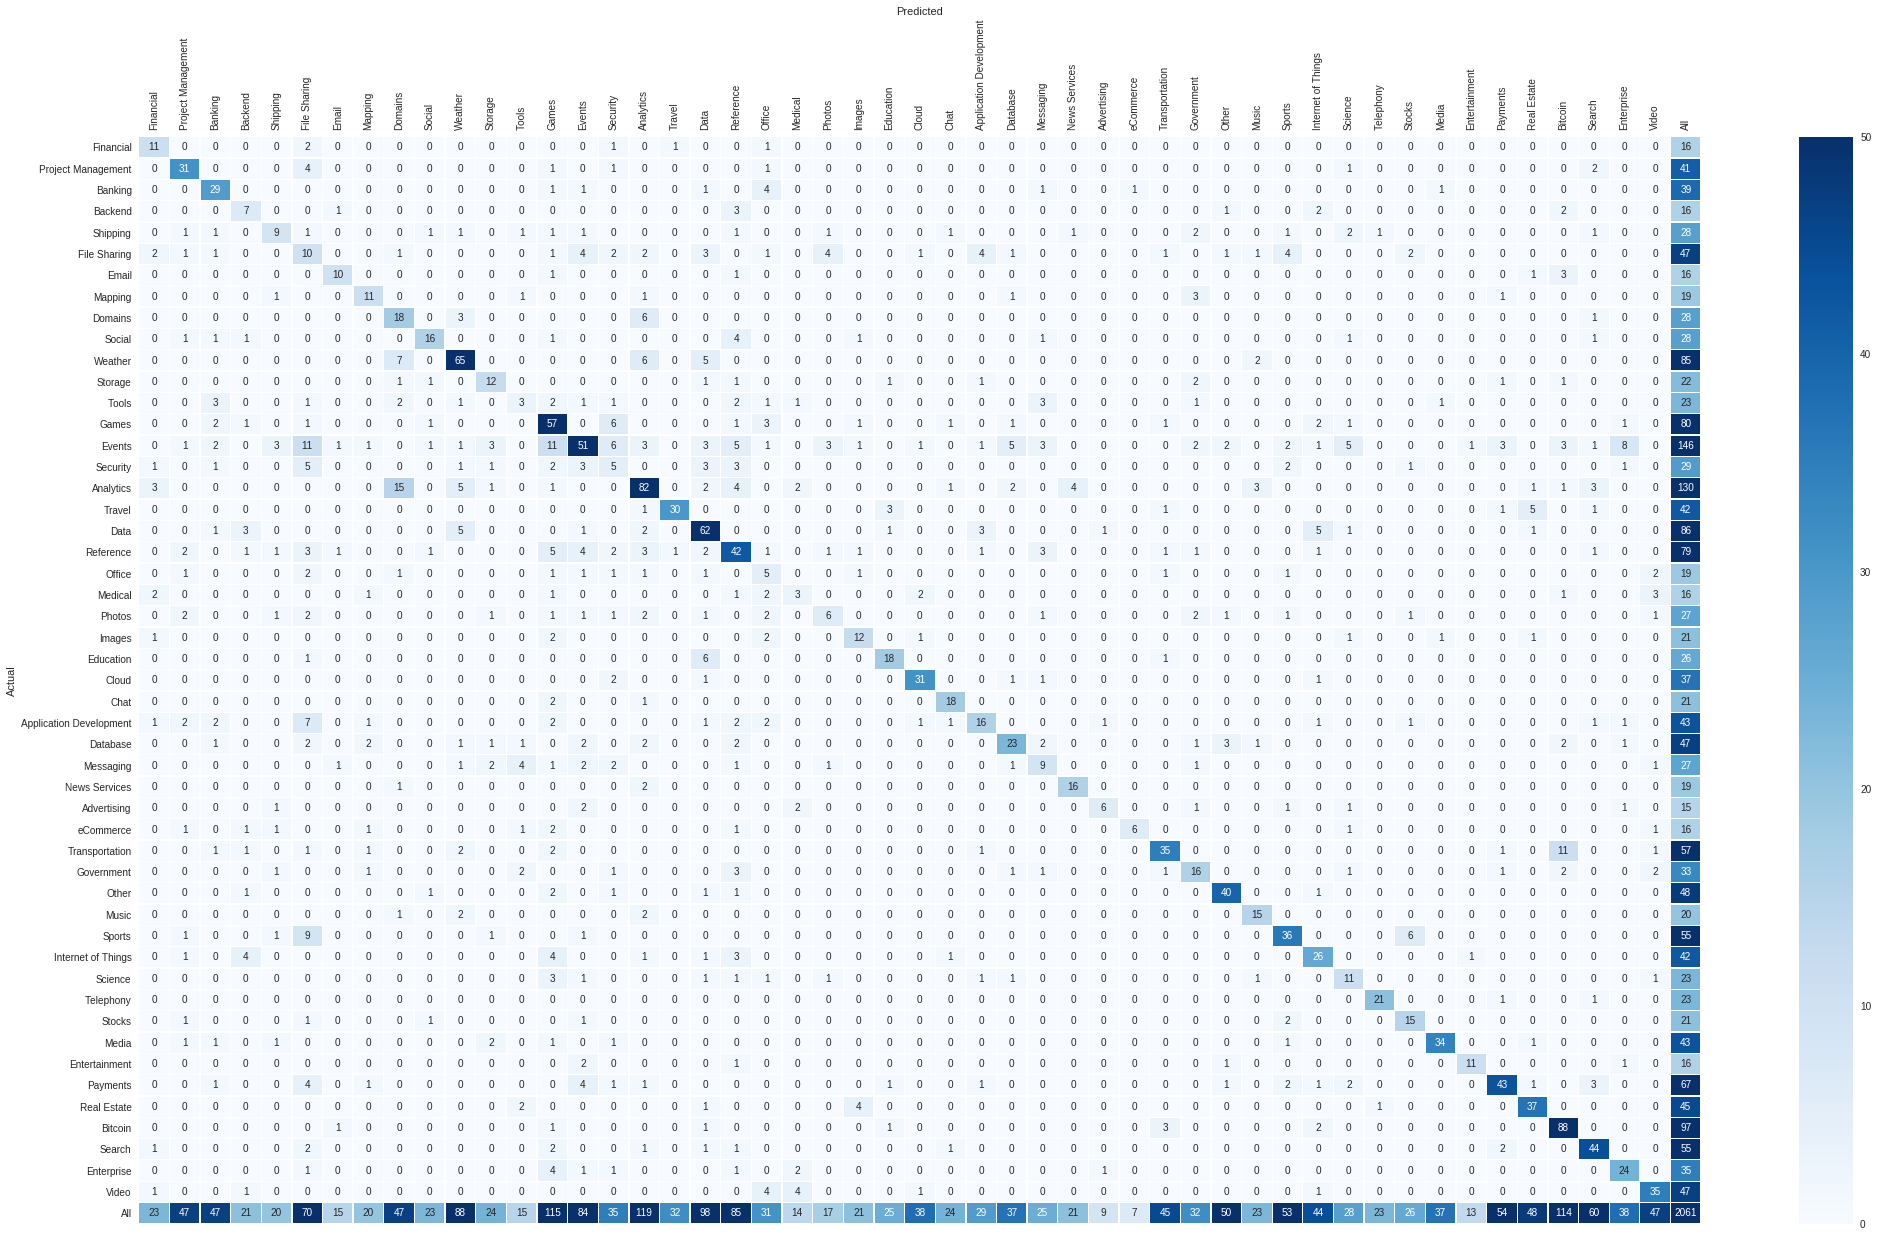

In [75]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('ServeNet/heatmap.pdf', format='pdf', dpi=300)